# DA10 Epoching
06/26/2023

In [1]:
import numpy as np
import mne
from glob import glob
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy.stats import zscore, linregress, ttest_ind, ttest_rel, ttest_1samp
import pandas as pd
from mne.preprocessing.bads import _find_outliers
import os 
import joblib
import emd
import re
import scipy

import warnings
warnings.filterwarnings('ignore')

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [2]:
import sys
sys.path.append('/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/scripts/saez_python_pipeline/LFPAnalysis')

In [3]:
from LFPAnalysis import lfp_preprocess_utils, sync_utils, analysis_utils, nlx_utils

In [4]:
base_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/'
anat_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/anat_recons/recon_labels/'
neural_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/data/'
behav_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/behavior_analysis/behavior_preprocessed/'

subj_id = 'DA10'
subj_format = ['nlx']
subj_site = ['UCD']


### Import Preprocessed Data

In [5]:
#mne_data_reref = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/wm_ref_ieeg.fif', preload=True)
mne_data_reref = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/bipolar_ref_ieeg.fif', preload=True)

photodiode_data = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/photodiode.fif', preload=True)

In [9]:
photodiode_data.info['line_freq'] = 60
# Notch out 60 Hz noise and harmonics 
photodiode_data.notch_filter(freqs=(60, 120, 180, 240),picks=['photodiode'])

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


<Raw | photodiode.fif, 1 x 1585280 (3170.6 s), ~12.1 MB, data loaded>

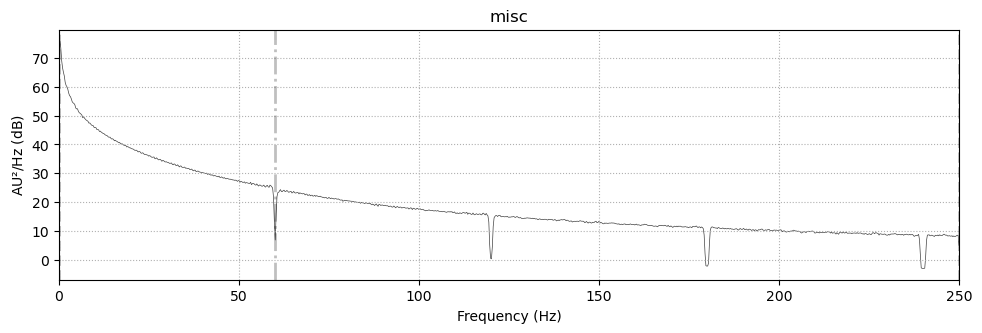

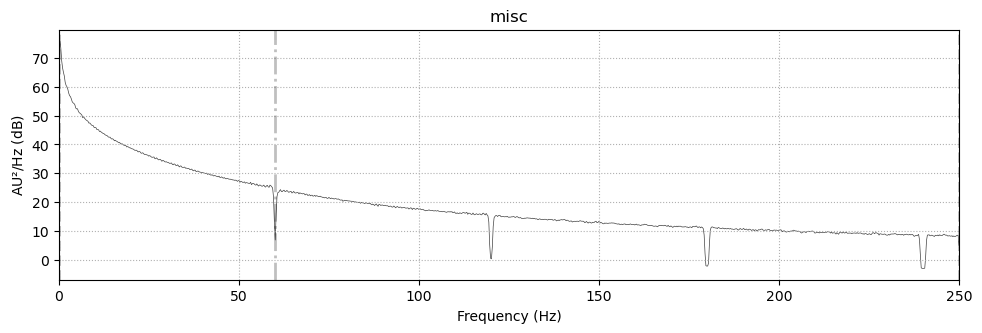

In [10]:
photodiode_data.plot_psd(picks=['photodiode'])

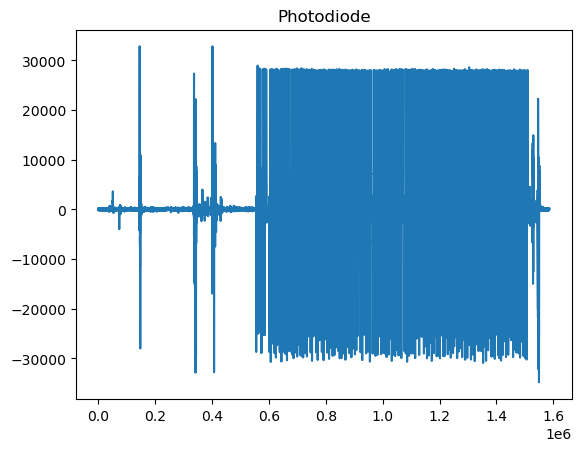

In [75]:
# Sanity check the photodiode
plt.plot(photodiode_data._data[0,:])
plt.title("Photodiode")
plt.show()

In [138]:
photodiode_data.ch_names

['photodiode']

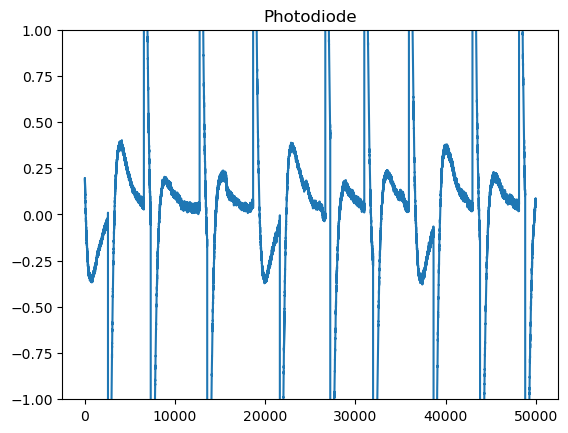

In [15]:
# Sanity check the photodiode
plt.plot(zscore(photodiode_data._data[0,1000000:1050000]))
plt.ylim(-1, 1)
plt.title("Photodiode")
plt.show()

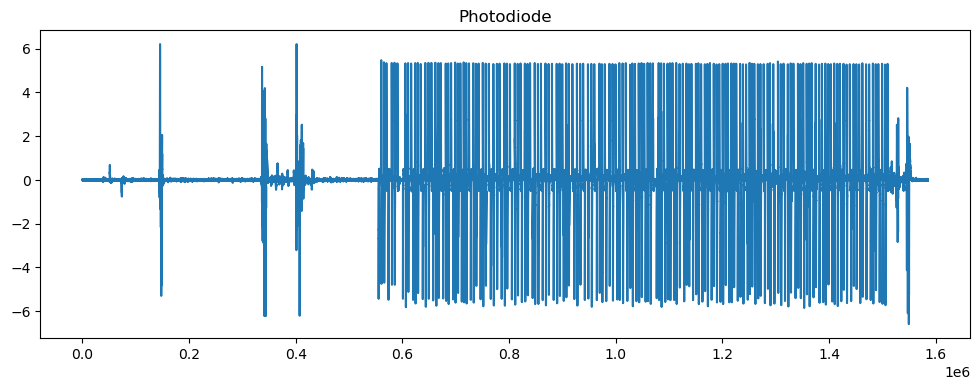

In [16]:
f, ax = plt.subplots(1,1, figsize=[12,4])
# Sanity check the photodiode
plt.plot(zscore(photodiode_data._data[0,:]))
# plt.plot(find_peaks(photodiode_data._data[0, :], height=20000)[0], 
#          30000*np.ones_like(find_peaks(photodiode_data._data[0, :], height=20000)[0]), 'o')
plt.title("Photodiode")
# plt.ylim(-1000, 5000)
plt.show()

In [226]:
bad_peak_indices_start = find_peaks(photodiode_data._data[0, :], height=4000)[0]- 100
bad_peak_indices_end = find_peaks(photodiode_data._data[0, :], height=4000)[0] + 1000
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.find_peaks.html

In [227]:
for (a,b) in zip(bad_peak_indices_start, bad_peak_indices_end):
    photodiode_data._data[0, a:b] = 0


In [228]:
photodiode_data._data[0, photodiode_data._data[0, :]<0] = 0
#clean data maybe zscore, 

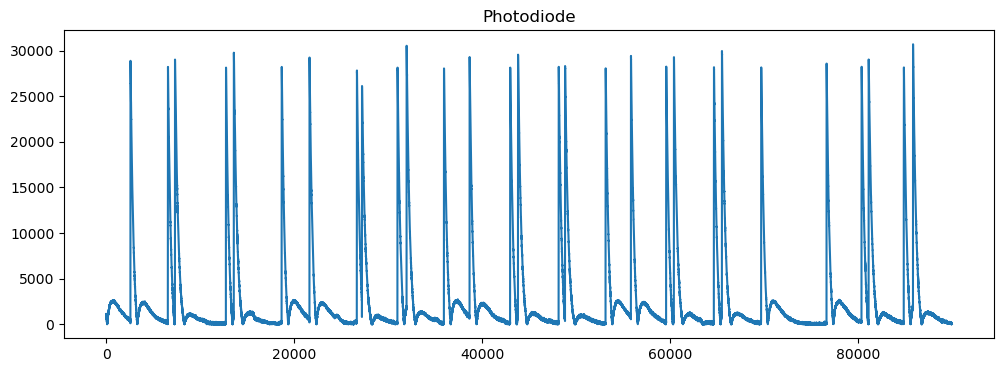

In [17]:
f, ax = plt.subplots(1,1, figsize=[12,4])
# Sanity check the photodiode
plt.plot(np.abs(photodiode_data._data[0,1000000:1090000]))
plt.title("Photodiode")
# plt.ylim(-1000, 5000)
plt.show()

In [238]:
find_peaks(zscore(photodiode_data._data[0, :]), height=6)[0].shape

(157,)

### Load Anat Recon Info 


In [9]:
# Load the electrode localization data
anat_file = glob(f'{anat_dir}{subj_id}_labels.csv')[0]
elec_locs = pd.read_csv(anat_file)
# Sometimes there's extra columns with no entries: 
elec_locs = elec_locs[elec_locs.columns.drop(list(elec_locs.filter(regex='Unnamed')))]

elec_locs

,label,BN246label,x,y,z,mni_x,mni_y,mni_z,gm,NMM,Anat,AnatMacro,BN246,YBA_1,ManualExamination
0,LAD1,rHipp_L,-14.399994,7.691510,-14.025760,-14.342856,-5.763441,-22.991499,Gray,Left PHG parahippocampal gyrus,Amygdala (LB),L ParaHippocampal Gyrus,L Hipp,Left parahippocampal gyrus A,NaN
1,LAD2,rHipp_L,-19.599993,7.291924,-14.025760,-20.094629,-6.129953,-22.869272,Gray,Left Amygdala,Amygdala (LB),L Hippocampus,L Hipp,Left amygdala inferior,NaN
2,LAD3,rHipp_L,-24.799993,6.892338,-13.626463,-25.843869,-6.282030,-22.239514,Gray,Left Amygdala,Amygdala (LB),L Hippocampus,L Hipp,Left amygdala inferior,NaN
3,LAD4,lAmyg_L,-29.599993,6.892338,-13.626463,-31.162715,-6.120036,-22.229235,Gray,Left Amygdala,Amygdala (LB),L Hippocampus,L Amyg,Left amygdala inferior,NaN
4,LAD5,Unknown,-34.799992,6.492752,-13.227165,-36.913993,-6.484951,-21.801391,White,Left Cerebral White Matter,Unknown,Unknown,Unknown,Unknown,WM
5,LAD6,Unknown,-39.599992,6.093167,-13.227165,-42.078518,-7.123732,-21.935039,White,Left Cerebral White Matter,Unknown,Unknown,Unknown,Unknown,WM
6,LAD7,aSTS_L,-44.799992,6.093167,-13.227165,-47.687519,-7.375745,-22.114078,White,Left Cerebral White Matter,Unknown,L Middle Temporal Gyrus,L MTG,Left superior middle temporal gyrus A,WM
7,LAD8,aSTS_L,-49.599992,5.693581,-12.827868,-52.874503,-7.931650,-21.592201,White,Left MTG middle temporal gyrus,Unknown,L Middle Temporal Gyrus,L MTG,Left superior middle temporal gyrus A,WM
8,LAD9,A21r_L,-54.799991,5.693581,-12.827868,-58.525474,-8.184515,-21.581147,White,Left MTG middle temporal gyrus,Unknown,L Middle Temporal Gyrus,L MTG,Left inferior middle temporal gyrus A,NaN
9,LHB1,cHipp_L,-26.399993,-14.685300,-10.432084,-26.654716,-29.075918,-14.281852,Gray,Left Hippocampus,Subiculum,L ParaHippocampal Gyrus,L Hipp,Left hippocampus body,NaN


## Load behavior

In [10]:
behav_df = pd.read_csv(f'{behav_dir}{subj_id}_pt_task_data')
behav_df = behav_df[behav_df.columns.drop(list(behav_df.filter(regex='Unnamed')))]
behav_df

,Round,Trial Num,TrialType,TrialOnset,ChoiceOnset,DecisionOnset,FeedbackOnset,RT,SafeBet,LowBet,...,weighted_low,p_g,p_s,util_rpe,util_tcpe,util_dcpe,util_tregret,util_dregret,util_trelief,util_drelief
0,1,128.0,loss,379.009074,379.012221,382.610063,384.626795,3.597842,-0.4,-1.44,...,-1.148452,0.282562,0.717438,0.000000,-1.148452,-0.304645,-1.148452,-0.304645,0.000000,0.000000
1,2,45.0,mix,390.119682,390.129793,392.605504,394.622769,2.475711,0.0,-1.10,...,-0.930400,0.279746,0.720254,-0.621199,-1.551599,-0.930400,-1.551599,-0.930400,0.000000,0.000000
2,3,84.0,gain,399.331027,399.331819,404.150264,406.167212,4.818446,0.5,0.00,...,0.000000,0.470099,0.529901,0.000000,0.000000,-0.039151,0.000000,0.000000,0.542503,-0.039151
3,4,42.0,mix,416.845493,416.846275,419.177541,419.185403,2.331266,0.0,-0.80,...,-0.725352,0.388176,0.611824,0.000000,0.725352,0.725352,0.000000,0.000000,0.725352,0.725352
4,5,104.0,loss,426.424513,426.425352,429.622041,431.638676,3.196689,-0.2,-0.44,...,-0.454541,0.527700,0.472300,0.454541,0.000000,0.490803,0.000000,0.000000,0.454541,0.490803
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,146,1.0,mix,2143.138202,2143.148032,2146.361413,2146.369284,3.213381,0.0,-0.30,...,-0.336930,0.297133,0.702867,0.000000,0.336930,0.336930,0.000000,0.000000,0.336930,0.336930
146,147,57.0,gain,2153.065555,2153.073785,2156.141033,2158.157286,3.067248,0.2,0.00,...,0.000000,0.548975,0.451025,0.000000,0.000000,0.064255,0.000000,0.000000,0.348418,0.064255
147,148,72.0,gain,2166.769473,2166.776112,2170.200739,2170.208657,3.424626,0.4,0.00,...,0.000000,0.425924,0.574076,0.000000,0.488543,0.488543,0.000000,0.000000,0.488543,0.488543
148,149,62.0,gain,2177.524504,2177.532319,2181.296300,2183.312601,3.763981,0.3,0.00,...,0.000000,0.441525,0.558475,-0.313324,-0.313324,-0.390149,-0.313324,-0.390149,0.000000,0.000000


In [11]:
beh_ts = behav_df['TrialOnset']

## Photodiode alignment

In [37]:
test_photo = photodiode_data

In [38]:
np.nanmax(photodiode_data._data)

32775.15234375

In [39]:
test_photo._data = np.abs(test_photo._data[0, :])-np.nanmax(test_photo._data[0, :]) #consider resaving photodiode 

In [14]:
# Synchronize to the photodiode or whatever your neural sync signal is
slope, offset = sync_utils.synchronize_data(beh_ts, 
                                            photodiode_data, 
                                            smoothSize=11, windSize=15, height=0.7)

13 blocks
.............

found matches for 15 of 201 pulses


In [29]:
print(slope,offset)

1.056331337693761 1022.4342083592669


In [12]:
slope=0.9999991556190556 #this worked but I can't recreate it...
offset=822.6778105046562

## Make epochs

In [38]:
photodiode_data.times[-1]-offset

2148.123791640733

In [13]:
behav_df['TrialOnset'].iloc[-1]

2188.7265314

In [14]:
behav_df = behav_df.drop(9,axis=0)

In [15]:
behav_df.iloc[9,]

Round                     11
Trial Num              123.0
TrialType               loss
TrialOnset        504.301396
ChoiceOnset       504.302214
DecisionOnset     506.604438
FeedbackOnset     508.620506
RT                  2.302224
SafeBet                 -0.4
LowBet                  -0.8
HighBet                  0.0
HighBetPos            bottom
GamblePos              right
ChoicePos              right
GambleChoice          gamble
Outcome                  bad
Profit                  -0.8
TotalProfit             7.67
GambleEV                -0.4
CR                       0.0
choiceEV                -0.4
RPE                     -0.4
totalCPE                -0.8
decisionCPE             -0.4
totalRegret             -0.8
decisionRegret          -0.4
totalRelief              0.0
decisionRelief           0.0
util_g             -0.725352
util_s             -0.843807
weighted_high            0.0
weighted_low       -0.725352
p_g                 0.589599
p_s                 0.410401
util_rpe      

In [16]:
beh_ts = behav_df['TrialOnset']

In [17]:
# IED removal requires that we set some parameters for IED detection. 
# 1. peak_thresh: how many stds should they exceed the baseline by? 
# 2. closeness_thresh: how close should they be allowed to be (in sec) to other candidate IEDs? 
# 3. width_thresh: how wide should they have to be (in sec)?

# Defaults:
IED_args = {'peak_thresh':4,
           'closeness_thresh':0.25, 
           'width_thresh':0.2}


In [18]:

# Create a dictionary with your event name (matching your dataframe), and the time-window for the event
evs = {'TrialOnset': [-1.0, 0],
       'DecisionOnset': [0, 3.0]}

In [19]:
epochs_all_evs = {f'{x}': np.nan for x in evs}
epochs_all_baseline = {f'{x}': np.nan for x in evs}

In [20]:
#only works with manual slope/offset saving
for event in evs.keys():
    # Make the epochs. 
    ev_epochs = lfp_preprocess_utils.make_epochs(load_path=f'{neural_dir}{subj_id}/bipolar_ref_ieeg.fif', 
                 elec_path=anat_file, 
                 slope=slope, offset=offset,
                 behav_name=event, behav_times=behav_df[event].values, 
                 ev_start_s=evs[event][0], ev_end_s=evs[event][1], buf_s = 1.0, 
                 downsamp_factor=1, IED_args=IED_args)

    epochs_all_evs[event] = ev_epochs


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 520 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 6348 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 6854 out of 6854 | elapsed:    2.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  39 out of  46 | elapsed:    0.7s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  46 out of  46 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 2040 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 6854 out of 6854 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: D

Should quality check IED removal in epoched data here ...

### Add metadata to epochs

In [21]:
for event in evs.keys():

    # Let's add our behavioral events to the metadata. Substitute this with the particulars for your behavioral dataframe. 

    event_metadata = epochs_all_evs[event].metadata.copy()
    
    #independent vars
    event_metadata['safe'] = behav_df['SafeBet'].tolist()
    event_metadata['low'] = behav_df['LowBet'].tolist()
    event_metadata['high'] = behav_df['HighBet'].tolist()
    event_metadata['profit'] = behav_df['Profit'].tolist()
    event_metadata['outcome'] = behav_df['Outcome'].tolist()
    #model-free vars
    event_metadata['g_ev'] = behav_df['GambleEV'].tolist()
    event_metadata['cr'] = behav_df['CR'].tolist()
    event_metadata['c_ev'] = behav_df['choiceEV'].tolist()
    event_metadata['rpe'] = behav_df['RPE'].tolist()
    event_metadata['tcpe'] = behav_df['totalCPE'].tolist()
    event_metadata['dcpe'] = behav_df['decisionCPE'].tolist()
    event_metadata['tregret'] = behav_df['totalRegret'].tolist()
    event_metadata['dregret'] = behav_df['decisionRegret'].tolist()
    event_metadata['trelief'] = behav_df['totalRelief'].tolist()
    event_metadata['drelief'] = behav_df['decisionRelief'].tolist()
    event_metadata['util_g'] = behav_df['util_g'].tolist()
    event_metadata['util_s'] = behav_df['util_s'].tolist()

    epochs_all_evs[event].metadata = event_metadata 
    
    

In [22]:
epochs_all_evs[event].metadata

,ltt1,ltt6,ltt3,ltt2,ltt4,ltt5,lad1-lad2,lad2-lad3,lad3-lad4,lad4-lad5,...,c_ev,rpe,tcpe,dcpe,tregret,dregret,trelief,drelief,util_g,util_s
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.720,-0.720,-1.44,-1.04,-1.44,-1.04,0.00,0.00,-1.148452,-0.843807
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.110,-1.210,-2.42,-1.10,-2.42,-1.10,0.00,0.00,-0.309200,0.000000
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.555,0.555,0.00,0.61,0.00,0.00,1.11,0.61,0.542503,0.581653
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000,0.000,-1.20,-1.20,0.00,0.00,0.80,0.80,-0.148756,0.000000
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.220,0.220,0.00,0.20,0.00,0.00,0.44,0.20,-0.454541,-0.490803
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[1562],NaN,NaN,...,0.000,0.000,-0.06,-0.06,0.00,0.00,0.30,0.30,-0.281497,0.000000
145,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[555],...,0.315,0.315,0.00,0.43,0.00,0.00,0.63,0.43,0.348418,0.284163
146,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000,0.000,-0.33,-0.33,0.00,0.00,0.40,0.40,0.390949,0.488543
147,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.275,-0.275,-0.55,-0.30,-0.55,-0.30,0.00,0.00,0.313324,0.390149


### Save epoched data

In [23]:
for event in evs.keys():
#     epochs_all_evs[event].save(f'{neural_dir}{subj_id}/epoch_{event}.fif', overwrite=True)
    epochs_all_evs[event].save(f'{neural_dir}{subj_id}/bipolar_epoch_{event}.fif', overwrite=True)

## Test TFRs

In [24]:
# Set some spectrogram parameters 
freqs = np.logspace(*np.log10([4, 200]), num=20)
n_cycles = 4  
sr = 500.0 #prob shouldn't have subject_id in here since not in loop...
buf = 1.0
buf_ix = int(buf*sr)

In [25]:
# Explicitly define a list of analysis events and the baseline event. Should correspond to the dict
analysis_evs = ['DecisionOnset']
baseline_ev = 'TrialOnset'
evs = {'TrialOnset': [-1.0, 0.25],
       'DecisionOnset': [0, 3.0]}

In [26]:
event = 'TrialOnset'
epochs = epochs_all_evs[event]
baseline_power_epochs = {}

# Let's make sure we only do this for good channels
good_chans = [x for x in epochs.ch_names if x not in epochs.info['bads']]
picks = [x for x in good_chans]

pow_struct = np.nan * np.ones([epochs._data.shape[0], 
                       epochs._data.shape[1], len(freqs), 
                       epochs._data.shape[-1]])

for ch_ix in np.arange(epochs._data.shape[1]): 
    ch_data = epochs._data[:, ch_ix:ch_ix+1, :]
    bad_epochs  = np.where(epochs.metadata[epochs.ch_names[ch_ix]].notnull())[0]
    good_epochs = np.delete(np.arange(ch_data.shape[0]), bad_epochs)
    ch_data = np.delete(ch_data, bad_epochs, axis=0)
    ch_pow = mne.time_frequency.tfr_array_morlet(ch_data, sfreq=epochs.info['sfreq'], 
                                        freqs=freqs, n_cycles=n_cycles, zero_mean=False, 
                                        use_fft=True, output='power', n_jobs=1)

    pow_struct[good_epochs, ch_ix, :, :] = ch_pow[:, 0, :, :]

temp_pow = mne.time_frequency.EpochsTFR(epochs.info, pow_struct, 
                                        epochs.times, freqs)
temp_pow.crop(tmin=evs[event][0], tmax=evs[event][1])

baseline_power_epochs[event] = temp_pow

In [27]:
power_epochs = {}

for event in analysis_evs:

    epochs = epochs_all_evs[event]

    # Let's make sure we only do this for good channels
    good_chans = [x for x in epochs.ch_names if x not in epochs.info['bads']]
    picks = [x for x in good_chans]

    pow_struct = np.nan * np.ones([epochs._data.shape[0], 
                           epochs._data.shape[1], len(freqs), 
                           epochs._data.shape[-1]])

    for ch_ix in np.arange(epochs._data.shape[1]): 
        ch_data = epochs._data[:, ch_ix:ch_ix+1, :]
        bad_epochs  = np.where(epochs.metadata[epochs.ch_names[ch_ix]].notnull())[0]
        good_epochs = np.delete(np.arange(ch_data.shape[0]), bad_epochs)
        ch_data = np.delete(ch_data, bad_epochs, axis=0)
        ch_pow = mne.time_frequency.tfr_array_morlet(ch_data, sfreq=epochs.info['sfreq'], 
                                            freqs=freqs, n_cycles=n_cycles, zero_mean=False, 
                                            use_fft=True, output='power', n_jobs=1)

        pow_struct[good_epochs, ch_ix, :, :] = ch_pow[:, 0, :, :]

    temp_pow = mne.time_frequency.EpochsTFR(epochs.info, pow_struct, 
                                            epochs.times, freqs)

    temp_pow.crop(tmin=evs[event][0], tmax=evs[event][1])

    baseline_corrected_power = lfp_preprocess_utils.zscore_TFR_across_trials(temp_pow.data, 
                                  baseline_power_epochs['TrialOnset'], mode='zscore', baseline_only=False)

    zpow = mne.time_frequency.EpochsTFR(epochs.info, baseline_corrected_power, 
                                    temp_pow.times, freqs)

    zpow.metadata = epochs_all_evs[event].metadata

    power_epochs[event] = zpow

In [78]:
power_epochs[event].data

array([[[[-1.58850536e+00, -1.59557631e+00, -1.60065035e+00, ...,
          -1.49442663e+00, -1.49516397e+00, -1.49482922e+00],
         [-1.12545516e-04, -4.75658464e-03, -8.29101657e-03, ...,
          -5.46409295e-01, -5.39621398e-01, -5.32431024e-01],
         [-4.86604417e-01, -4.83902539e-01, -4.80103460e-01, ...,
           1.78525424e-01,  1.90140192e-01,  2.01705769e-01],
         ...,
         [ 2.37877617e+00,  1.65239358e+00,  8.63991774e-01, ...,
           2.93240736e+00,  3.43764223e+00,  2.99611474e+00],
         [ 3.14605704e+00,  2.92180774e+00,  1.76873159e+00, ...,
           2.43479506e+00,  2.31917773e+00,  1.71031476e+00],
         [ 6.02873163e+00,  4.09104737e+00,  9.91693154e-01, ...,
           8.97286494e-01,  5.97074826e-01,  4.11365634e-01]],

        [[-1.02714259e+00, -1.00989580e+00, -9.91720103e-01, ...,
          -1.35944720e+00, -1.35916585e+00, -1.35799439e+00],
         [-7.19992735e-01, -7.14276475e-01, -7.07894678e-01, ...,
          -6.49090500e

In [32]:
power_epochs['DecisionOnset'].ch_names

['ltt1',
 'ltt6',
 'ltt3',
 'ltt2',
 'ltt4',
 'ltt5',
 'lad1-lad2',
 'lad2-lad3',
 'lad3-lad4',
 'lad4-lad5',
 'lad5-lad6',
 'lad6-lad7',
 'lad7-lad8',
 'lad8-lad9',
 'lhb1-lhb2',
 'lhb2-lhb3',
 'lhb3-lhb4',
 'lhb4-lhb5',
 'lhb5-lhb6',
 'lhb6-lhb7',
 'lhb7-lhb8',
 'lhb8-lhb9',
 'lhh1-lhh2',
 'lhh2-lhh3',
 'lhh3-lhh4',
 'lhh4-lhh5',
 'lhh5-lhh6',
 'lhh6-lhh7',
 'lhh7-lhh8',
 'lhh8-lhh9',
 'lof1-lof2',
 'lof2-lof3',
 'lof3-lof4',
 'lof4-lof5',
 'lof5-lof6',
 'lof6-lof7',
 'lof7-lof8',
 'lof8-lof9',
 'ltt7-ltt8',
 'ltpo1-ltpo2',
 'ltpo2-ltpo3',
 'ltpo3-ltpo4',
 'ltpo4-ltpo5',
 'ltpo5-ltpo6',
 'ltpo6-ltpo7',
 'ltpo7-ltpo8']

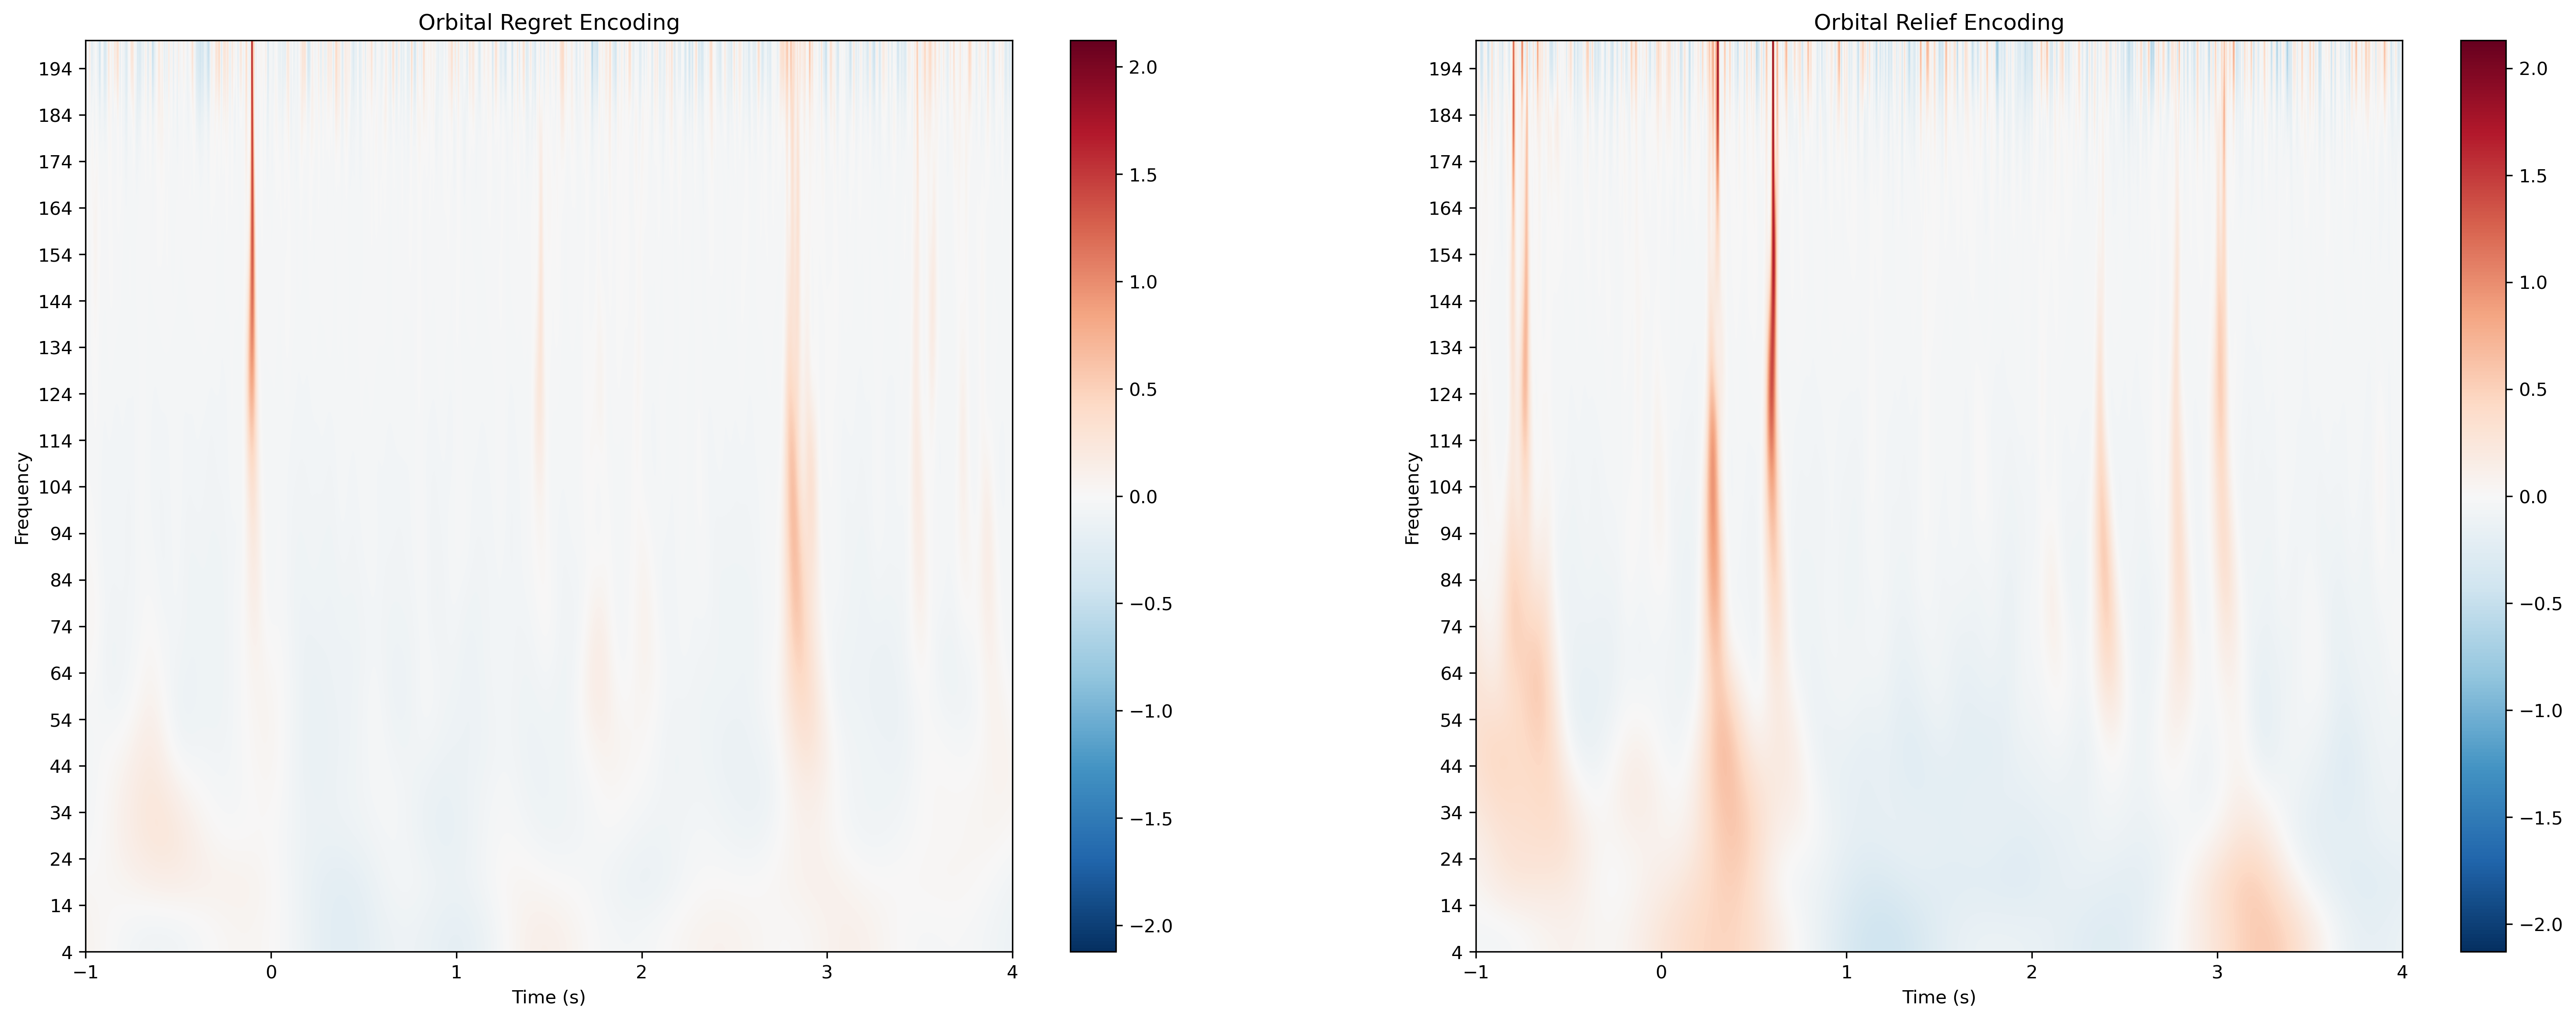

In [28]:
# rois = ['orbital', 'cingulate', 'amygdala', 'insular', 'hippocampus','superior frontal', 'middle frontal', 'inferior frontal']
region = 'orbital'
freqs = np.logspace(*np.log10([4, 200]), num=20)
# band definitions for y-axis
#freqs = np.logspace(*np.log10([4,200]),num=40)
yticks = np.arange(4,200,step=10)

#cond_names = [ev(0,-,+),cr,rpe(0,-,+),profit(0,-,+),total_cpe(-,+),decision_cpe(-,+),regret(-,0),relief(0,+)]
# task condition to contrast 
conditions = ["(dcpe<0)",
             "(dcpe>0)"]


cond_name = 'cpe'

event = 'DecisionOnset'



#elec_data = elec_data.dropna(how='all')
anode_list = [x.split('-')[0] for x in epochs_all_evs[event].ch_names] #having problem here because anode names does not match elec_df!!
#new_anode_list = lfp_preprocess_utils.match_elec_names(anode_list,elec_data.label)
elec_df = elec_locs[elec_locs.label.str.lower().isin(anode_list)]
#elec_df = elec_data[elec_data.label.str.lower().isin(new_anode_list[0])]



elec_df['label'] = epochs_all_evs[event].ch_names

picks = analysis_utils.select_picks_rois(elec_df, region)
#print(picks)
#print(subj_id,len(picks))


fig, ax = plt.subplots(1, 2, figsize=(25, 9), dpi=300)
for ix, cond in enumerate(conditions):
    plot_title = ['Regret','Relief']
    region_name = region[0].upper() + region[1:]
    # Set the times for 
    times = epochs_all_evs[event].times
    plot_data = np.nanmean(np.nanmean(power_epochs[event][cond].copy().pick_channels(picks).data, axis=0), axis=0)

    im = ax[ix].imshow(plot_data,
              extent=[times[0], times[-1], freqs[0], freqs[-1]], interpolation='Bicubic',
              aspect='auto', origin='lower', cmap='RdBu_r',vmin = -np.nanmax(np.abs(plot_data)), vmax = np.nanmax(np.abs(plot_data)))
    ax[ix].set(yticks=yticks, xlabel='Time (s)', ylabel='Frequency',title=f'{region_name} {plot_title[ix]} Encoding')
    
    fig.colorbar(im, ax=ax[ix])
#     plt.savefig(f'{base_dir}figs/final_total_cpe_TFRs/{subj_id}_{region}_{cond_name}.png', dpi='figure', format='png', metadata=None,
#         bbox_inches=None, pad_inches=0.1,

#         facecolor='auto', edgecolor='auto',
#         backend=None)   

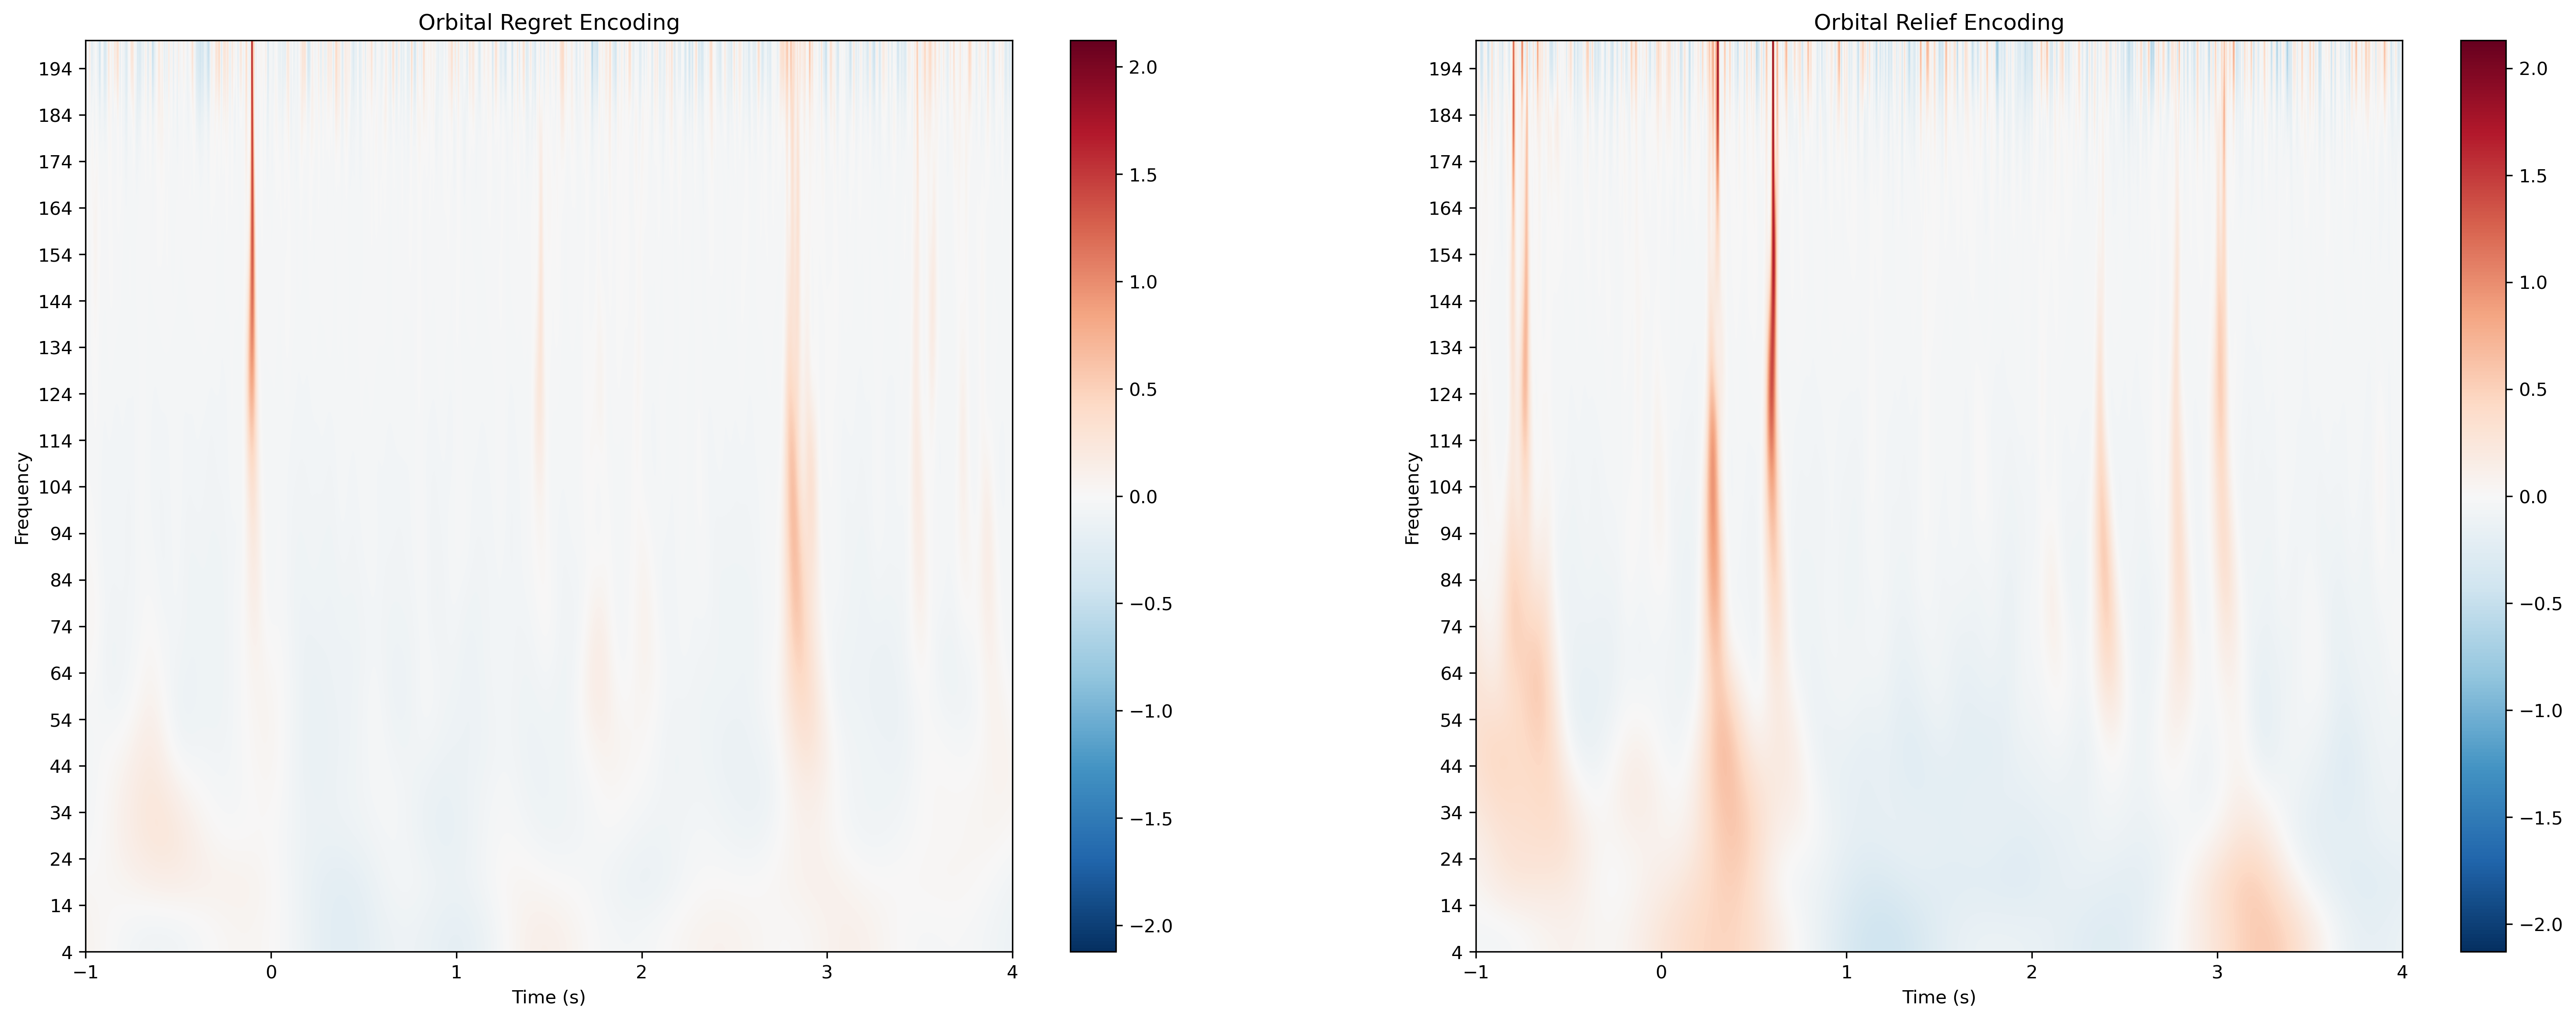

In [29]:
fig

In [35]:
ch_name = 'lof1-lof2'

In [37]:
picks

['lhh3-lhh4', 'lhh4-lhh5']

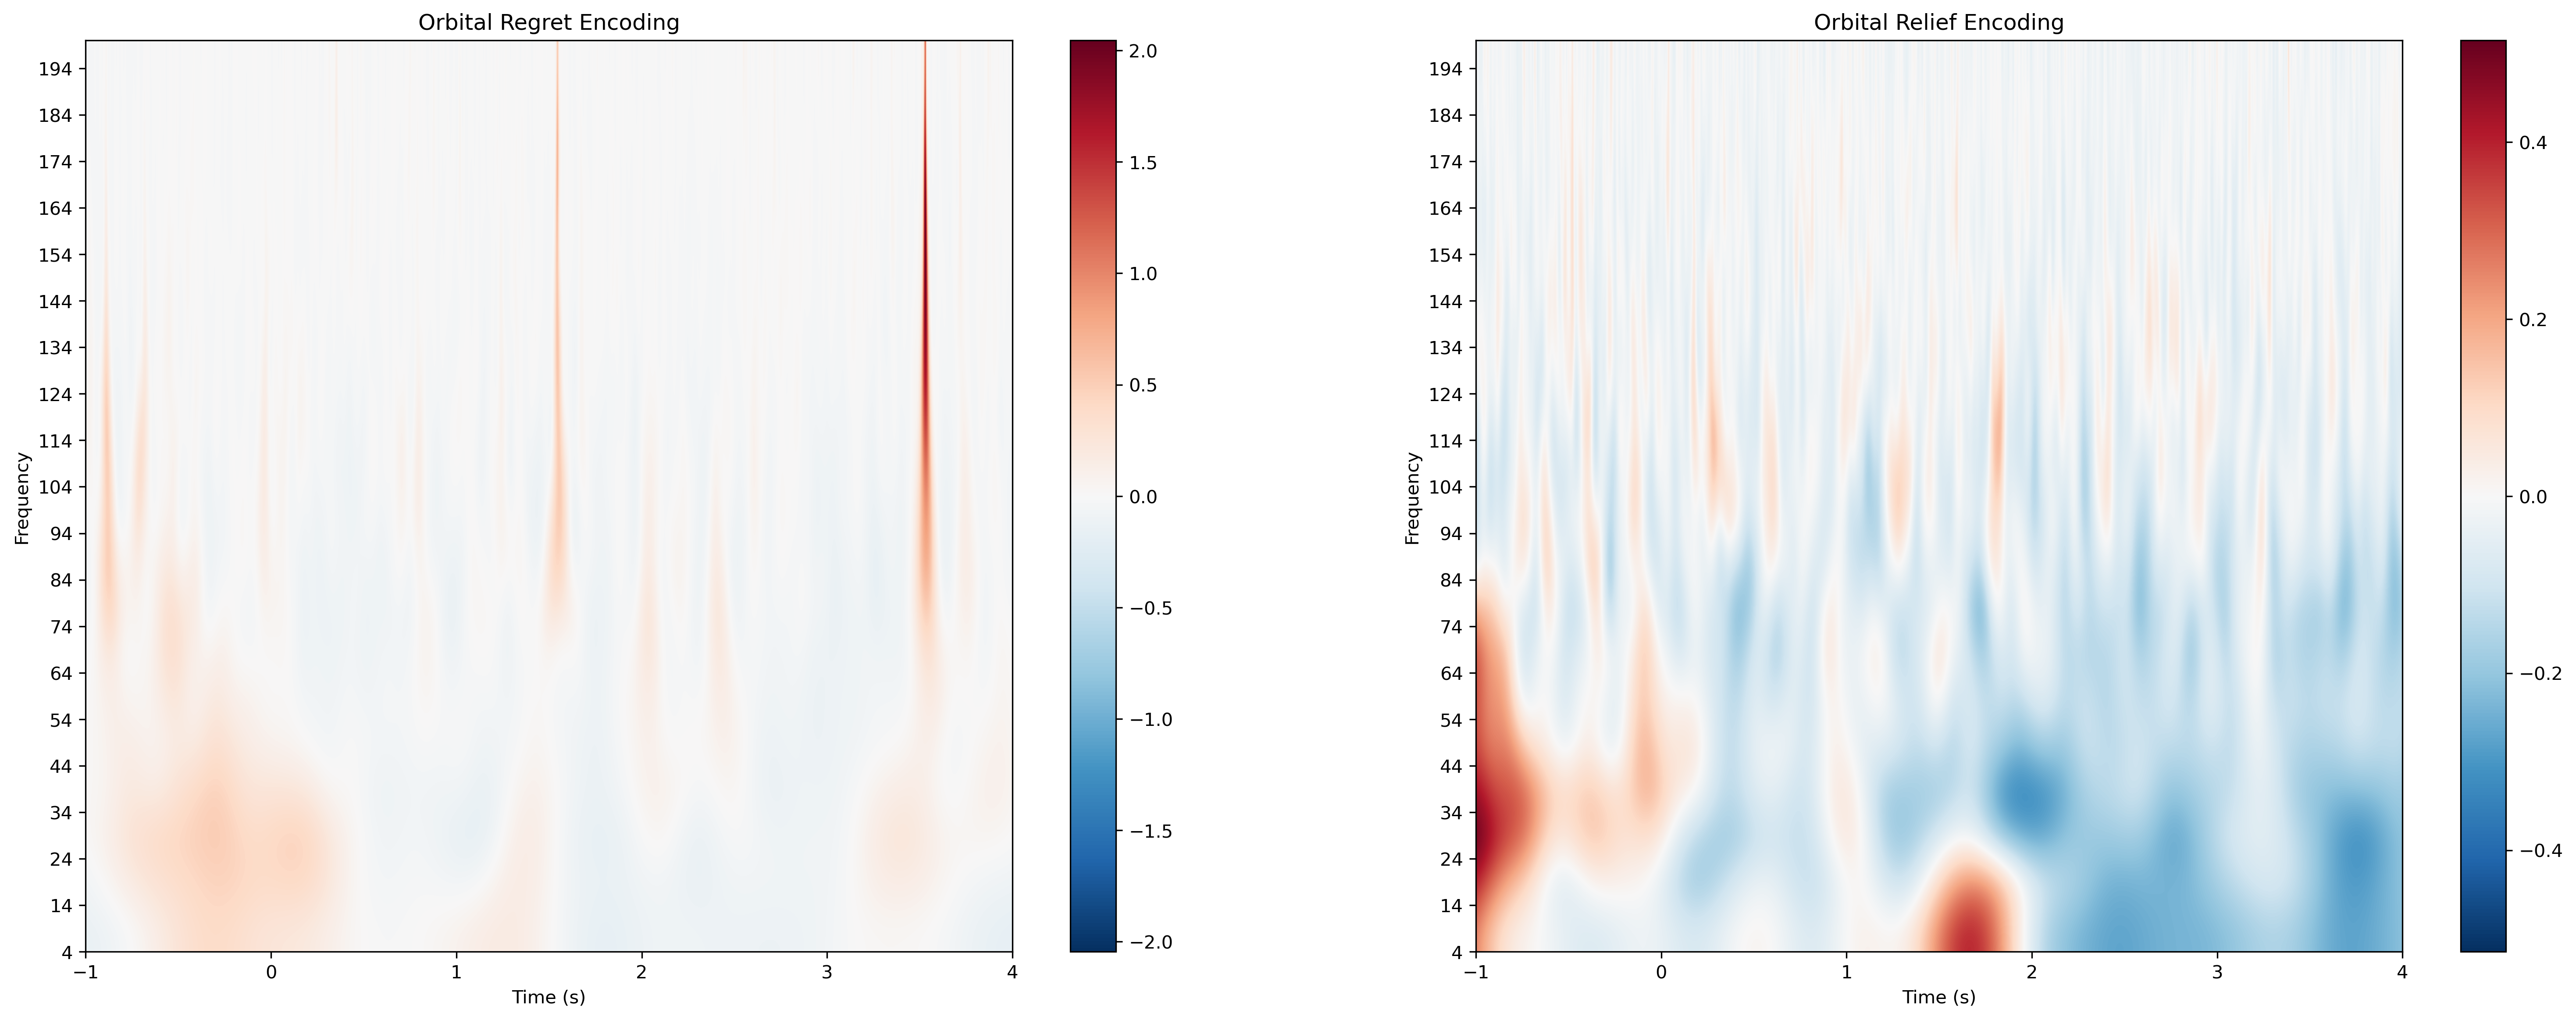

In [38]:
ch_name = ['lof1-lof2']
freqs = np.logspace(*np.log10([4, 200]), num=20)
# band definitions for y-axis
#freqs = np.logspace(*np.log10([4,200]),num=40)
yticks = np.arange(4,200,step=10)

#cond_names = [ev(0,-,+),cr,rpe(0,-,+),profit(0,-,+),total_cpe(-,+),decision_cpe(-,+),regret(-,0),relief(0,+)]
# task condition to contrast 
conditions = ["(dcpe<0)",
             "(dcpe>0)"]


cond_name = 'cpe'

event = 'DecisionOnset'




fig, ax = plt.subplots(1, 2, figsize=(25, 9), dpi=300)
for ix, cond in enumerate(conditions):
    plot_title = ['Regret','Relief']
    #region_name = region[0].upper() + region[1:]
    # Set the times for 
    times = epochs_all_evs[event].times
    plot_data = np.nanmean(np.nanmean(power_epochs[event][cond].copy().pick_channels(ch_name).data, axis=0), axis=0)

    im = ax[ix].imshow(plot_data,
              extent=[times[0], times[-1], freqs[0], freqs[-1]], interpolation='Bicubic',
              aspect='auto', origin='lower', cmap='RdBu_r',vmin = -np.nanmax(np.abs(plot_data)), vmax = np.nanmax(np.abs(plot_data)))
    ax[ix].set(yticks=yticks, xlabel='Time (s)', ylabel='Frequency',title=f'{region_name} {plot_title[ix]} Encoding')
    
    fig.colorbar(im, ax=ax[ix])

In [33]:
cond

'(dcpe>0)'

In [36]:
power_epochs['DecisionOnset'][cond].copy().pick_channels(ch_name).data

ValueError: include/exclude must be list, tuple, ndarray, or "bads". You provided type <class 'str'>